# Get aggregated comment features

In [1]:
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import os
import random
import numpy as np

from multiprocessing import Pool, cpu_count
from functools import partial

from sklearn.metrics import r2_score

# for auto reload a module after editing.
%load_ext autoreload
%autoreload 2

In [2]:
file = "./data/movie_list/metadata_2014-2019.csv"
movie_df = pd.read_csv(file)
with open("./data/movie_list/_excluded_movies.txt", "r") as f:
    excluded_movies = f.read().split('\n')
movie_df = movie_df[~movie_df['Title'].isin(excluded_movies)]
movie_df = movie_df[movie_df.budget > 1]
movie_df = movie_df.reset_index(drop=True)
print("Movie number: {}".format(movie_df.shape[0]))

Movie number: 696


## 1. Generate Agg. Trailer Features

- Input: matadata file, trailer comment files.
- Output: movie_df file, which include both metadata features and trailer features.
- Steps:
    1. for each movie in the matadata_df, stack the comments from all its trailers.
    2. process the sentiment score of each comment using process_sentiment_score() function.
    3. generate agg. features: 'trailer_commentCount', 'trailer_mean_sentiment', 'trailer_pos_sentiment_ratio', 'trailer_neg_sentiment_ratio'.
    4. Add the agg. trailer features onto matadata_df, save it as movie_df.

In [3]:
trailer_list = "./data/trailer_list/trailer_list_2014-2019.csv"
trailer_list_df = pd.read_csv(trailer_list)
trailer_list_df.loc[:, 'Year'] = trailer_list_df.loc[:, 'release_date'].apply(lambda x : int(x[:4]))
year_mean_viewCount = {}
year_mean_commentCount = {}
for year in range(2014, 2020):
    year_mean_viewCount[year] = trailer_list_df[trailer_list_df['Year'] == year].viewCount.mean()
    year_mean_commentCount[year] = trailer_list_df[trailer_list_df['Year'] == year].commentCount.mean()
year_mean_commentCount

{2014: 2574.1770186335402,
 2015: 3694.431137724551,
 2016: 6485.597484276729,
 2017: 5993.121037463977,
 2018: 10679.009933774834,
 2019: 16272.624535315985}

In [4]:
def process_sentiment_score(x):
    if x > 0.2:
        return 1
    if x < -0.2:
        return -1
    return 0

In [5]:
trailer_comments_dir = "./data/trailer_comments"
def func(movie_df):
    for i in movie_df.index:
        tt_id = movie_df.loc[i, 'tt_id']
        movie_year = int(movie_df.loc[i, 'release_date'][:4])

        df = trailer_list_df[trailer_list_df.tt_id == tt_id]
        trailer_viewCount_tot = df.loc[:, 'viewCount'].sum()
        trailer_viewCount_norm = trailer_viewCount_tot / year_mean_viewCount[movie_year]
        movie_df.loc[i, 'trailer_viewCount'] = trailer_viewCount_norm

        trailer_likeCount_tot = df.loc[:, 'likeCount'].sum()
        trailer_dislikeCount_tot = df.loc[:, 'dislikeCount'].sum()
        like_dislike_ratio = trailer_likeCount_tot / trailer_dislikeCount_tot
        movie_df.loc[i, 'trailer_like_dislike_ratio'] = like_dislike_ratio

        trailer_list = df[df["comment_disabled"] == False]['trailer_id'].to_list()
        trailer_list = [f for f in trailer_list if f + ".csv" in os.listdir(trailer_comments_dir)]
        if len(trailer_list) == 0:
            continue
        comment_df = pd.DataFrame()
        for tr_id in trailer_list:
            tr_df = pd.read_csv(os.path.join(trailer_comments_dir, tr_id + ".csv"))
            tr_df = tr_df[tr_df["used_for_model"] == True]    # Only use comments before cut-off date.
            comment_df = comment_df.append(tr_df, ignore_index=True)
        comment_df.loc[:, 'sentiment_score_processed'] = comment_df.loc[:, 'sentiment_score'].apply(process_sentiment_score)
        agg_sentiment = comment_df.loc[:, 'sentiment_score_processed'].sum() / comment_df.shape[0]
        pos_sentiment_ratio = comment_df[comment_df['sentiment_score_processed'] == 1].shape[0] / comment_df.shape[0]
        neg_sentiment_ratio = comment_df[comment_df['sentiment_score_processed'] == -1].shape[0] / comment_df.shape[0]
        movie_df.loc[i, 'trailer_mean_sentiment'] = agg_sentiment
        movie_df.loc[i, 'trailer_commentCount'] = comment_df.shape[0] / year_mean_commentCount[movie_year]
        movie_df.loc[i, 'trailer_pos_sentiment_ratio'] = pos_sentiment_ratio
        movie_df.loc[i, 'trailer_neg_sentiment_ratio'] = neg_sentiment_ratio
    return movie_df
    
df_split = np.array_split(movie_df, cpu_count())
t0 = time.time()
with Pool(cpu_count()) as p:
    df_list = p.map(func, df_split)
movie_df = pd.concat(df_list)
t1 = time.time()
print("Finished. Time: {0:.1f} s.".format(t1 - t0))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Finished. Time: 24.0 s.


In [6]:
movie_df.to_csv("./data/movie_2014-2019.csv", index=False)

## 2. EDA of Agg. Trailer Features

### 2.1 trailer_viewCount v.s. trailer_commentCount

- 'trailer_viewCount' is the total count of views (until now). So it shouldn't be used to train the model (to avoid data leakage).
- 'trailer_commentCount' is the count of comment until the cut-off date (before movie release). It is proper to be used.
- This session is to show 'trailer_commentCount' can take the role of 'trailer_viewCount' for model training.

0.4552455996509184


Text(0, 0.5, 'trailer_viewCount')

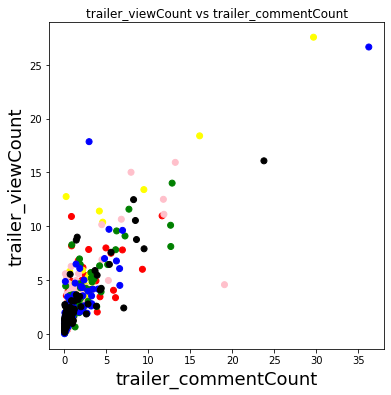

In [9]:
x = 'trailer_commentCount'
y = 'trailer_viewCount'
c = 'Year'
colors = {2014:'red', 2015:'yellow', 2016:'pink', 2017:'green', 2018:'blue', 2019: 'black'}
print(r2_score(movie_df.dropna()[x], movie_df.dropna()[y]))

plt.figure(figsize=(6, 6))
plt.scatter(movie_df[x], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]))
plt.title('{} vs {}'.format(y, x))
plt.xlabel(x, fontsize=18)
plt.ylabel(y, fontsize=18)
# plt.legend()

### 2.2 trailer_commentCount

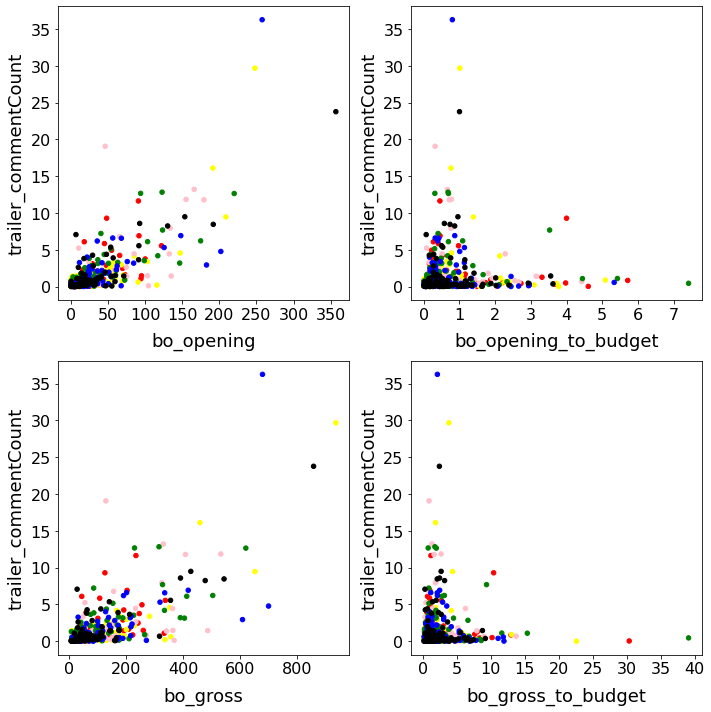

In [12]:
movie_df.loc[:, 'bo_opening_to_budget'] = movie_df['bo_opening'] / movie_df['budget']
movie_df.loc[:, 'bo_gross_to_budget'] = movie_df['bo_gross'] / movie_df['budget']

y = 'trailer_commentCount'
x1 = 'bo_opening'
x2 = 'bo_opening_to_budget'
x3 = 'bo_gross'
x4 = 'bo_gross_to_budget'
c = 'Year'
colors = {2014:'red', 2015:'yellow', 2016:'pink', 2017:'green', 2018:'blue', 2019: 'black'}

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.scatter(movie_df[x1], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x1, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2, 2, 2)
plt.scatter(movie_df[x2], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x2, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2, 2, 3)
plt.scatter(movie_df[x3], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x3, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2, 2, 4)
plt.scatter(movie_df[x4], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x4, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()


### 2.3 trailer_mean_sentiment

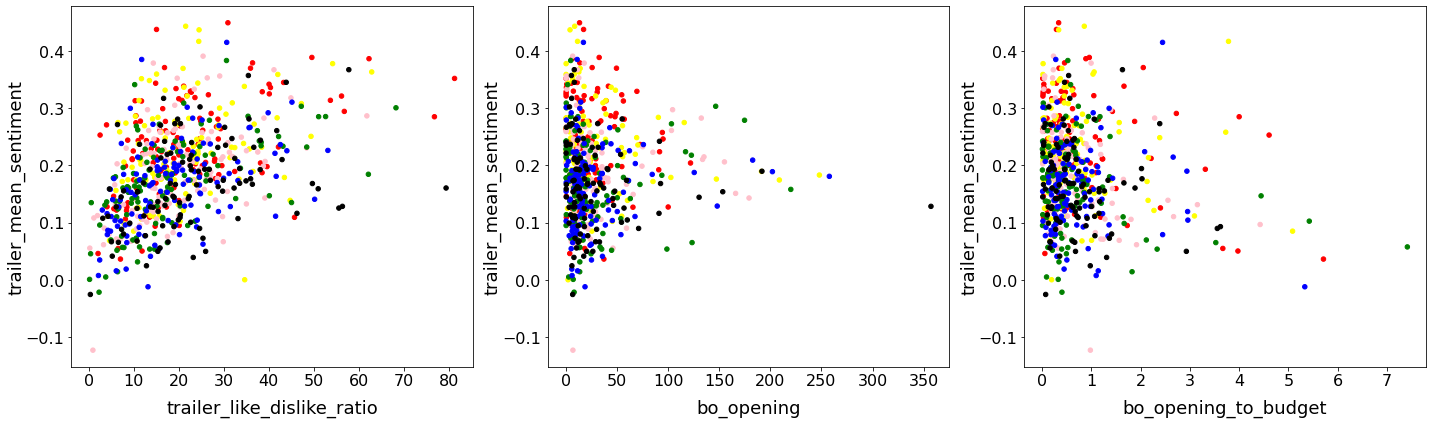

In [16]:
movie_df.loc[:, 'bo_opening_to_budget'] = movie_df['bo_opening'] / movie_df['budget']
movie_df.loc[:, 'bo_gross_to_budget'] = movie_df['bo_gross'] / movie_df['budget']


y = 'trailer_mean_sentiment'
x1 = 'trailer_like_dislike_ratio'
x2 = 'bo_opening'
x3 = 'bo_opening_to_budget'
c = 'Year'
colors = {2014:'red', 2015:'yellow', 2016:'pink', 2017:'green', 2018:'blue', 2019: 'black'}

fig, ax = plt.subplots(figsize = (20, 6))
plt.subplot(1, 3, 1)
plt.scatter(movie_df[x1], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x1, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 2)
plt.scatter(movie_df[x2], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x2, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 3)
plt.scatter(movie_df[x3], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x3, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()


### 2.4 trailer_pos_sentiment_ratio

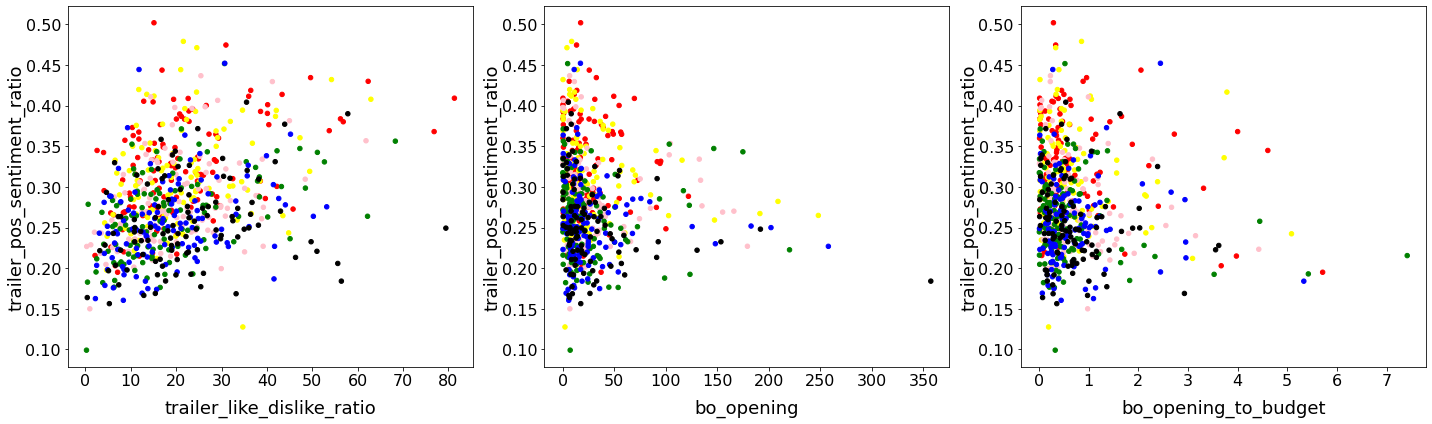

In [17]:
movie_df.loc[:, 'bo_opening_to_budget'] = movie_df['bo_opening'] / movie_df['budget']
movie_df.loc[:, 'bo_gross_to_budget'] = movie_df['bo_gross'] / movie_df['budget']


y = 'trailer_pos_sentiment_ratio'
x1 = 'trailer_like_dislike_ratio'
x2 = 'bo_opening'
x3 = 'bo_opening_to_budget'
c = 'Year'
colors = {2014:'red', 2015:'yellow', 2016:'pink', 2017:'green', 2018:'blue', 2019: 'black'}

fig, ax = plt.subplots(figsize = (20, 6))
plt.subplot(1, 3, 1)
plt.scatter(movie_df[x1], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x1, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 2)
plt.scatter(movie_df[x2], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x2, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 3)
plt.scatter(movie_df[x3], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x3, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()

### 2.5 trailer_neg_sentiment_ratio

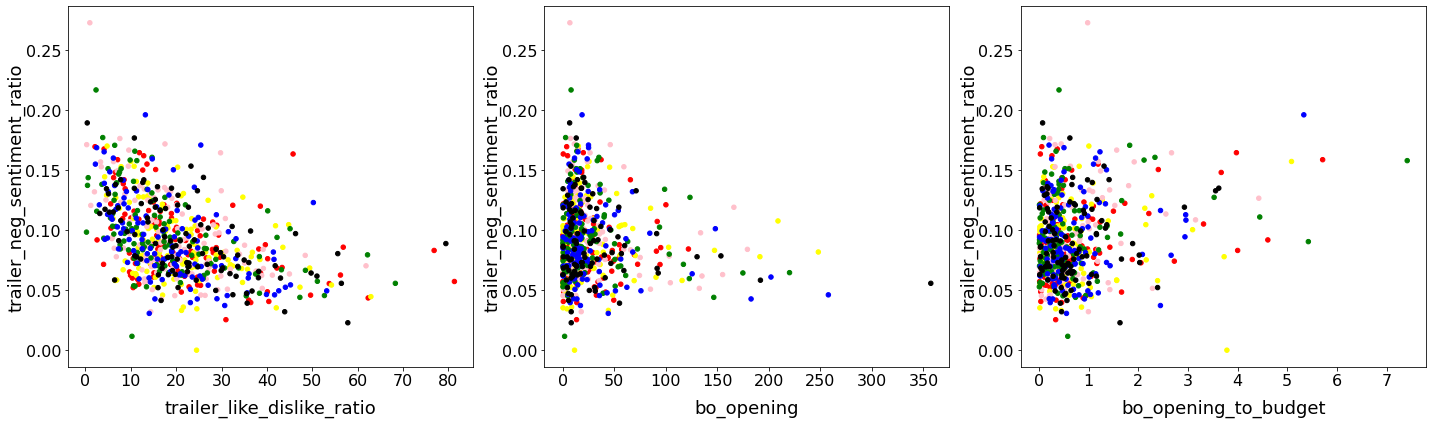

In [18]:
movie_df.loc[:, 'bo_opening_to_budget'] = movie_df['bo_opening'] / movie_df['budget']
movie_df.loc[:, 'bo_gross_to_budget'] = movie_df['bo_gross'] / movie_df['budget']


y = 'trailer_neg_sentiment_ratio'
x1 = 'trailer_like_dislike_ratio'
x2 = 'bo_opening'
x3 = 'bo_opening_to_budget'
c = 'Year'
colors = {2014:'red', 2015:'yellow', 2016:'pink', 2017:'green', 2018:'blue', 2019: 'black'}

fig, ax = plt.subplots(figsize = (20, 6))
plt.subplot(1, 3, 1)
plt.scatter(movie_df[x1], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x1, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 2)
plt.scatter(movie_df[x2], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x2, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 3)
plt.scatter(movie_df[x3], movie_df[y], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(x3, fontsize=18, labelpad=10)
plt.ylabel(y, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()

### 2.6 trailer_mean_sentiment v.s. trailer_pos_sentiment_ratio v.s. trailer_neg_sentiment_ratio'

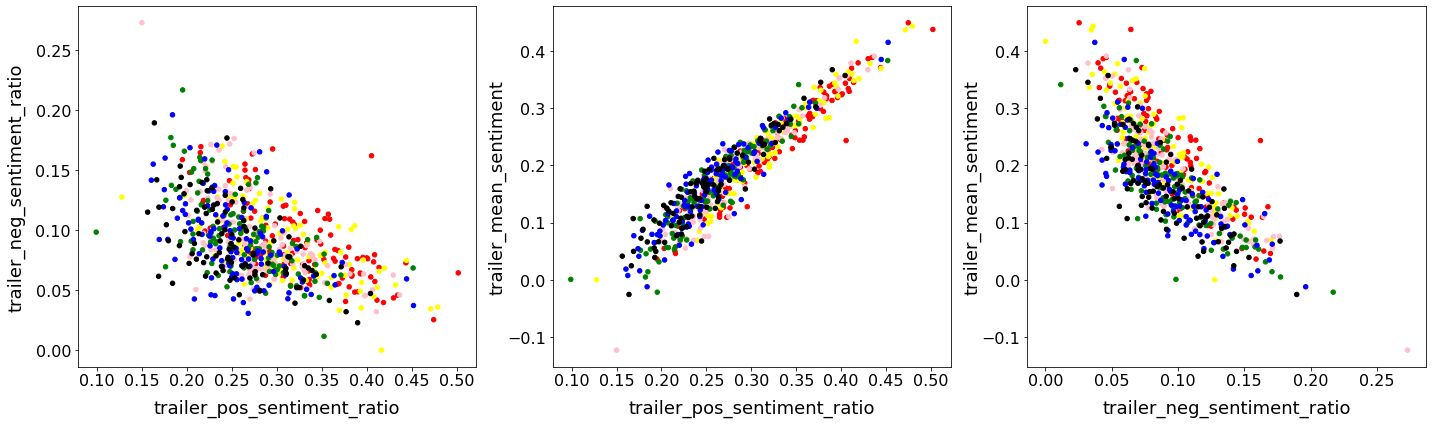

In [19]:
s1 = 'trailer_pos_sentiment_ratio'
s2 = 'trailer_neg_sentiment_ratio'
s3 = 'trailer_mean_sentiment'
c = 'Year'
colors = {2014:'red', 2015:'yellow', 2016:'pink', 2017:'green', 2018:'blue', 2019: 'black'}

fig, ax = plt.subplots(figsize = (20, 6))
plt.subplot(1, 3, 1)
plt.scatter(movie_df[s1], movie_df[s2], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(s1, fontsize=18, labelpad=10)
plt.ylabel(s2, fontsize=18, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 2)
plt.scatter(movie_df[s1], movie_df[s3], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(s1, fontsize=18, labelpad=10)
plt.ylabel(s3, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 3)
plt.scatter(movie_df[s2], movie_df[s3], c=movie_df[c].apply(lambda x: colors[x]), s=20)
# plt.title('{} vs {}'.format(y, x1), fontsize=22, y=1.04)
plt.xlabel(s2, fontsize=18, labelpad=10)
plt.ylabel(s3, fontsize=18, labelpad=0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()

([<matplotlib.axis.YTick at 0x7f85290d8150>,
 <a list of 4 Text major ticklabel objects>)

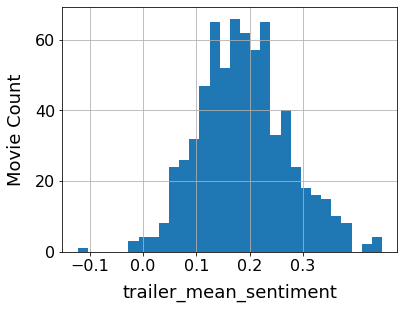

In [25]:
movie_df.trailer_mean_sentiment.hist(bins=30, figsize=(6, 4.5))
plt.xlabel("trailer_mean_sentiment", fontsize=18, labelpad=10)
plt.ylabel("Movie Count", fontsize=18, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(np.arange(-0.1, 0.32, step=0.1))
plt.yticks(np.arange(0, 80, step=20))

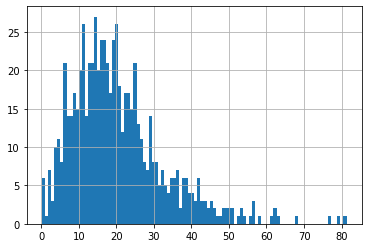

In [21]:
movie_df.trailer_like_dislike_ratio.hist(bins=100)

In [22]:
movie_df[movie_df.Title == 'Terminator: Dark Fate']

,Year,Rank,Title,tt_id,rl_id,release_date,company,mpaa,genres,runtime,...,bo_gross,imdb_score,trailer_viewCount,trailer_like_dislike_ratio,trailer_mean_sentiment,trailer_commentCount,trailer_pos_sentiment_ratio,trailer_neg_sentiment_ratio,bo_opening_to_budget,bo_gross_to_budget
630,2019,45,Terminator: Dark Fate,tt6450804,rl3103950337,2019-11-01,Paramount Pictures,R,"Action,Adventure,Sci-Fi",128,...,62.253077,6.3,4.097832,5.077526,0.066414,4.261943,0.196819,0.130405,0.15694,0.336503


In [23]:
movie_df[movie_df.Title == 'Avengers: Endgame']

,Year,Rank,Title,tt_id,rl_id,release_date,company,mpaa,genres,runtime,...,bo_gross,imdb_score,trailer_viewCount,trailer_like_dislike_ratio,trailer_mean_sentiment,trailer_commentCount,trailer_pos_sentiment_ratio,trailer_neg_sentiment_ratio,bo_opening_to_budget,bo_gross_to_budget
593,2019,1,Avengers: Endgame,tt4154796,rl3059975681,2019-04-26,Walt Disney Studios,PG-13,"Action,Adventure,Drama,Sci-Fi",181,...,858.373,8.4,16.081213,56.410046,0.128279,23.758306,0.184046,0.055767,1.003132,2.41116


In [24]:
movie_df[movie_df.Title == 'The Lion King']

,Year,Rank,Title,tt_id,rl_id,release_date,company,mpaa,genres,runtime,...,bo_gross,imdb_score,trailer_viewCount,trailer_like_dislike_ratio,trailer_mean_sentiment,trailer_commentCount,trailer_pos_sentiment_ratio,trailer_neg_sentiment_ratio,bo_opening_to_budget,bo_gross_to_budget
594,2019,2,The Lion King,tt6105098,rl3321923073,2019-07-19,Walt Disney Studios,PG,"Adventure,Animation,Drama,Family,Musical",118,...,543.638043,6.9,10.544394,24.410109,0.189647,8.455796,0.248012,0.058366,0.73758,2.090916


In [26]:
movie_df[movie_df.trailer_mean_sentiment < 0]

,Year,Rank,Title,tt_id,rl_id,release_date,company,mpaa,genres,runtime,...,bo_gross,imdb_score,trailer_viewCount,trailer_like_dislike_ratio,trailer_mean_sentiment,trailer_commentCount,trailer_pos_sentiment_ratio,trailer_neg_sentiment_ratio,bo_opening_to_budget,bo_gross_to_budget
339,2016,122,Norm of the North,tt1594972,rl880576001,2016-01-15,Lionsgate,PG,"Adventure,Animation,Comedy,Family",90,...,17.062499,3.4,0.283900,0.959601,-0.123077,0.040089,0.150000,0.273077,0.977734,2.437500
442,2017,99,Rough Night,tt4799050,rl1283360257,2017-06-16,Sony Pictures Releasing,R,"Comedy,Crime,Thriller",101,...,22.105643,5.2,0.869827,2.325499,-0.021739,0.483554,0.195307,0.217046,0.400214,1.105282
543,2018,76,Truth or Dare,tt6772950,rl3355608577,2018-04-13,Universal Pictures,PG-13,"Horror,Thriller",100,...,41.411015,5.2,1.821070,13.205372,-0.012299,0.571027,0.183995,0.196294,5.333673,11.831719
678,2019,107,Cats,tt5697572,rl2684847617,2019-12-20,Universal Pictures,PG,"Comedy,Drama,Family,Fantasy,Musical",110,...,27.166770,2.7,2.427008,0.387105,-0.025715,7.066531,0.163839,0.189554,0.069683,0.285966
